In [1]:
import sys
sys.path.append('../src/')

# Tutorial: Impact of the parameter in the solutions of the BOT problems

As outlined in the paper, Branched Optimal Transport (BOT) problems extend the scope of classical Optimal Transport problems by introducing subadditive transportation costs $m_{ij}$ along edges $(i,j)$. This subadditivity arises from the inclusion of the parameter $\alpha \in [0,1]$ in the cost function, defined as:

$$
\sum_{(i,j)\in E} m_{ij}^\alpha \ ||x_i-x_j||_2,
$$

where $x_i$ and $x_j$ denote the coordinates of nodes $i$ and $j$ respectively. The subadditivity manifests in various forms depending on the specific value of $\alpha$. In this tutorial, we delve deeper into this concept and its implications.


### Step 1: Setup and Imports
To get started, we will import the necessary modules and configure our environment. The following modules are imported in this code snippet:

In [2]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
#-------------------------------------------
import utils
import iterative_geometry_solver as igs
import greedy_topology_optimization as gto 

### Step 2: Define Problem Parameters
Next, the code defines the problem parameters. The snippet contains the following lines:

In [28]:
seed=20
np.random.seed(seed)
num_terminals = 20

- `np.random.seed(138)`: Sets the random seed to ensure reproducibility of results.
- `num_terminals`: Specifies the number of terminals in the problem.

### Step 3: Generate Random Problem
The following code snippet uses the `generate_random_bot_problem` function to generate a random problem. It randomly determines the number of sources and sinks and retrieves the problem dictionary, which includes the coordinates, supply, and demand arrays. This allows us to work with a randomly generated BOT problem.

In [29]:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = utils.generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                       max_length=1.)

The content of the dictionary `bot_problem_dict` is as follows:

- `'al'`: The value of $\alpha$.
- `'coords_sources'`: A 2D NumPy array representing the coordinates of the sources. Each row corresponds to the coordinates of a source point in a two-dimensional space.
- `'coords_sinks'`: A 2D NumPy array representing the coordinates of the sinks. Each row corresponds to the coordinates of a sink point in a two-dimensional space.
- `'supply_arr'`: A 1D NumPy array representing the supply values for each source. Each element in the array corresponds to the supply value of a source point.
- `'demand_arr'`: A 1D NumPy array representing the demand values for each sink. Each element in the array corresponds to the demand value of a sink point.

We can see that the parameter $\alpha$ in this example is:

In [30]:
bot_problem_dict['al']

0.8874117053874859

We won't use this value but others in a certain range of interest.

Let's now extract the information defining the problem into a set of variables.

In [31]:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

Notice that in this case, the number of sources and sinks is:

In [32]:
print(len(coords_sources))
print(len(coords_sinks))

4
16


### Step 4: Initialize Star Graph
To start off, we will define an initial topology to work with. Similar to the approach taken in the first tutorial, we will use a star graph as our starting point. This initial topology will serve as the foundation for further optimization and refinement in our solution to the BOT problem.

In [33]:
# init star graph:
topo = nx.Graph()
for node in range(len(supply_arr) + len(demand_arr)):
    topo.add_edge(-1, node)

Notice that this graph has the following properties:

In [34]:
# The number of nodes
num_nodes = topo.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = topo.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 21
Number of edges: 20


And it looks like this:

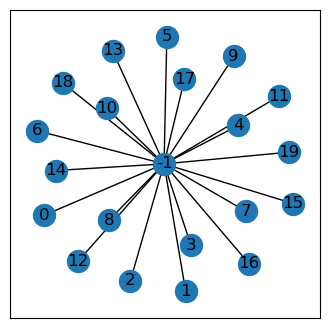

In [35]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(topo, seed = 1)
nx.draw_networkx(topo, pos = pos, node_size = 250, with_labels = True)

This graph can be considered as our initial approximation of the solution to the problem of connecting the given sources and sinks.

Final result for al=0.01, after 179 iterations and 4.99 seconds.


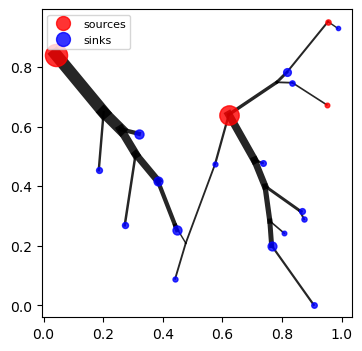

Final result for al=0.25, after 148 iterations and 2.55 seconds.


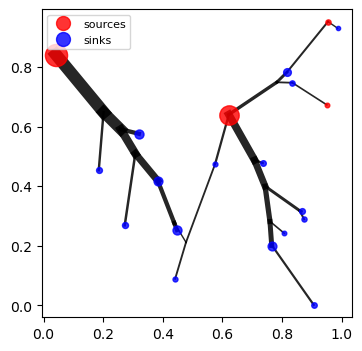

Final result for al=0.5, after 164 iterations and 5.86 seconds.


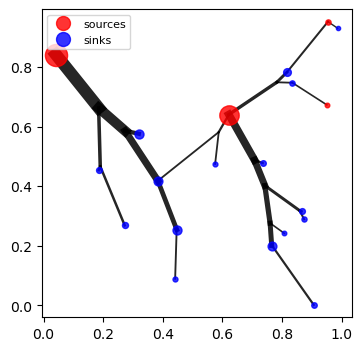

Final result for al=0.75, after 158 iterations and 4.75 seconds.


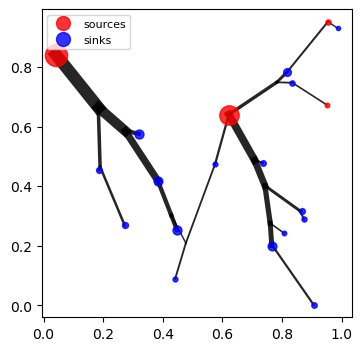

Final result for al=0.99, after 20 iterations and 0.69 seconds.


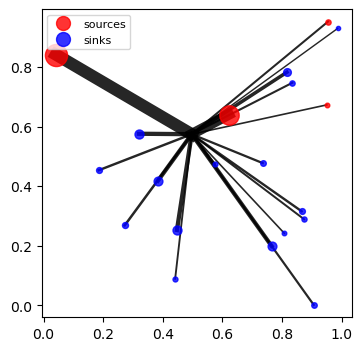

In [36]:
import matplotlib.pyplot as plt

alphas = [0.01, 0.25, 0.50, 0.75, 0.99]

for i, al in enumerate(alphas):
    
    # We create a copy of the graph
    topo_copy = topo.copy()
    # We run the geometry optimization step
    cost, coords_iter = igs.iterative_geometry_solver(topo_copy,
                                                      supply_arr, 
                                                      demand_arr, 
                                                      coords_sources, 
                                                      coords_sinks, 
                                                      al,
                                                      relative_improvement_threshold=1e-6,
                                                      min_iterations=-1,
                                                      max_iterations=1000,
                                                      plot=False,
                                                      title="",
                                                      fov=None,
                                                      save=False,
                                                      #save_name=f"img_{i+1}",
                                                      figsize=(4, 4))

    T = 0
    keep_going = True
    iteration = 0
    sample_edge_list = list(topo.edges())
    
    # We run the topology optimization
    time0 = time.time()
    while keep_going and iteration < 60000:
        iteration += 1
        topo_copy, sample_edge_list, cost, coords_iter, accepted = gto.monte_carlo_step(topo_copy, 
                                                                                   sample_edge_list, 
                                                                                   cost,
                                                                                   coords_iter, 
                                                                                   bot_problem_dict,
                                                                                   temperature=T)
        # check if converged:
        if len(sample_edge_list) == 0:
            # this means that we have stuck with one topology for an entire run through.
            keep_going = False

    print(f"Final result for al={al}, after {iteration} iterations and {np.round(time.time() - time0, 2)} seconds.")
    utils.visualise_BOT_solution(topo_copy, 
                       coords_iter, 
                       supply_arr, 
                       demand_arr, 
                       title="", fov=None, save=False, save_name="img",
                       figsize = (4,4),
                                fs = 8)
    plt.show()

As evident from the plots, the parameter $\alpha$ has a significant impact on the resulting topology of the solution. The value of $\alpha$ determines the characteristics of the network, varying from branching structures when alpha is close to 0, to more straight lines and direct connections when $\alpha$ approaches 1. By adjusting the value of $\alpha$, we can observe the transformation of the network's topology, allowing us to explore a wide range of potential solutions for the problem at hand.

Congratulations!  We have successfully constructed solutions to BOT problems with different subadditivity rates.